Predict Disease

In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from keras.models import Sequential
from keras.layers import Dropout,Dense,Flatten,Activation,Conv2D,MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [6]:
#Read Data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train_path='train_/'
test_path='test/'

In [7]:
train.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


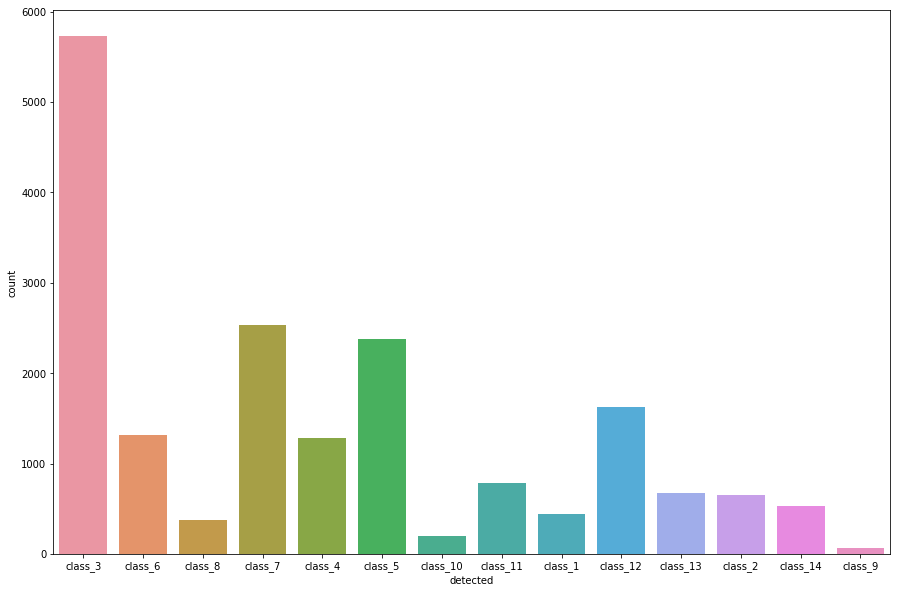

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(x='detected',data=train)


In [20]:
cls={v:k+1 for k,v in enumerate(set(train.detected))}
inv_cls={v:k for k,v in cls.items()}
y_train=train['detected'].apply(lambda v: cls[v])
y_train=to_categorical(y_train)

In [24]:
# Read Images
from tqdm import tqdm
img=[]
for i in tqdm(train.image_name.values):
    im=cv2.imread(train_path+i)
    im=cv2.resize(im,(128,128))
    img.append(im)

100%|██████████| 18577/18577 [09:12<00:00, 33.61it/s]


In [25]:
train_img=np.array(img,np.float32)

In [26]:
train_img.shape

(18577, 128, 128, 3)

In [27]:
# Rescale Images
train_img=train_img/255.

In [28]:
#Normalize 
mean=train_img.mean(axis=0)
std=train_img.std(axis=0)
train_img=(train_img-mean)/std

Create Model

In [32]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1],activation='softmax'))
                

In [34]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
__________

In [36]:
early_stops=EarlyStopping(patience=3,monitor='val_acc')

Fit the model on training set

In [ ]:
model.fit(train_img,y_train,batch_size=128,epochs=5,validation_split=0.3,callbacks=[early_stops])